In [1]:
import numpy as np
import pandas as pd
from helper.Loader import Loader
import matplotlib.pyplot as plt
import seaborn as sns
from helper.get_data import pivot_table_all

In [2]:
database = 'market_research'
table_name = 'ohlc'
start_date = "2012-01-01"
end_date = "2022-01-26"

"""
"""
wind_codes = pd.read_csv('bank.txt',sep=' ', header=None,)
wind_codes = wind_codes[0].to_list()
field = "symbol,date,close"
# options = "PriceAdj=DP"
loader = Loader(start_date, end_date, database, table_name, field, None)
df = loader.fetch_data(database, table_name, wind_codes, field)
df.head()
table = pivot_table_all(df, 'date', 'symbol', 'close')
# print(table)


Data found!


In [3]:
df0 = table['000001.SZ']
df0.dropna(inplace=True)  # drop missing values in the feature set
df0 = df0.to_frame(name='000001.SZ')
df0 = df0.to_period(freq ='D')
df0.head()

000001.SZ
date                 
1991-04-03      49.00
1991-04-04      48.76
1991-04-05      48.52
1991-04-08      48.04
1991-04-09      47.80

In [4]:
df0 = df0["2021-05":]
df0['pct'] = df0['000001.SZ'].pct_change()
df0['cumprod'] = (df0['pct'] + 1).cumprod()
df0['Time'] = np.arange(len(df0.index))
# df0 = df0["2021-05":]
df0

000001.SZ       pct   cumprod  Time
date                                           
2021-05-06    2609.64       NaN       NaN     0
2021-05-07    2670.72  0.023406  1.023406     1
2021-05-10    2649.62 -0.007900  1.015320     2
2021-05-11    2612.98 -0.013828  1.001280     3
2021-05-12    2615.20  0.000850  1.002131     4
...               ...       ...       ...   ...
2022-02-07    1834.40  0.035378  0.702932   183
2022-02-08    1883.65  0.026848  0.721805   184
2022-02-09    1887.00  0.001778  0.723088   185
2022-02-10    1901.55  0.007711  0.728664   186
2022-02-11    1913.87  0.006479  0.733385   187

[188 rows x 4 columns]

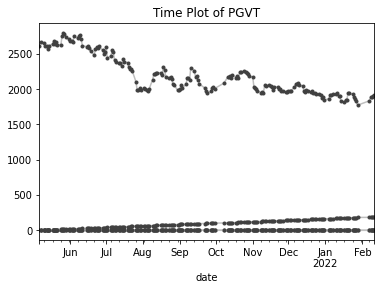

In [5]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
ax = df0.plot(**plot_params)
ax.set_title('Time Plot of PGVT');

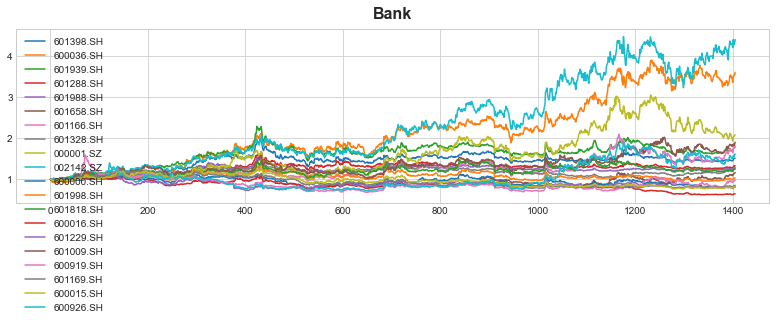

In [6]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
fig, ax = plt.subplots()
for wind_code in wind_codes:
    df0 = table[wind_code]
    # df0.dropna(inplace=True)
    df0 = df0.to_frame(name=wind_code)
    df0 = df0.to_period(freq ='D')
    df0 = df0["2016-05":]
    df0['Time'] = np.arange(len(df0.index))
    df0['pct'] = df0[wind_code].pct_change()
    df0['cumprod'] = (df0['pct'] + 1).cumprod()
    # ax = df0.plot(**plot_params)
    ax.plot('Time', 'cumprod', data=df0, label=wind_code)
    # ax = sns.regplot(x='Time', y=wind_code, data=df0, ci=None, scatter_kws=dict(color='0.25'))
    ax.set_title('Bank');
    _ = ax.legend()

In [7]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [8]:
# for wind_code in wind_codes:
#     df0 = table[wind_code]
#     df0.dropna(inplace=True)
#     df0 = df0.to_frame(name=wind_code)
#     df0 = df0.to_period(freq ='D')
#     # df0 = df0["2019-05":]
#     plot_periodogram(df0[wind_code]);

In [9]:
df0 = table['002142.SZ']
df0.dropna(inplace=True)  # drop missing values in the feature set
df0 = df0.to_frame(name='002142.SZ')
df0 = df0.to_period(freq ='D')
df0.head()

002142.SZ
date                 
2007-07-19      22.13
2007-07-20      24.34
2007-07-23      25.31
2007-07-24      25.98
2007-07-25      28.58

In [10]:
X = df0.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)
# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
X

002142.SZ  day  week  dayofyear  year
date                                             
2007-07-19    22.1300    3    29        200  2007
2007-07-20    24.3400    4    29        201  2007
2007-07-23    25.3100    0    30        204  2007
2007-07-24    25.9800    1    30        205  2007
2007-07-25    28.5800    2    30        206  2007
...               ...  ...   ...        ...   ...
2022-02-07    90.6388    0     6         38  2022
2022-02-08    89.7524    1     6         39  2022
2022-02-09    88.0903    2     6         40  2022
2022-02-10    88.8659    3     6         41  2022
2022-02-11    90.6831    4     6         42  2022

[3543 rows x 5 columns]

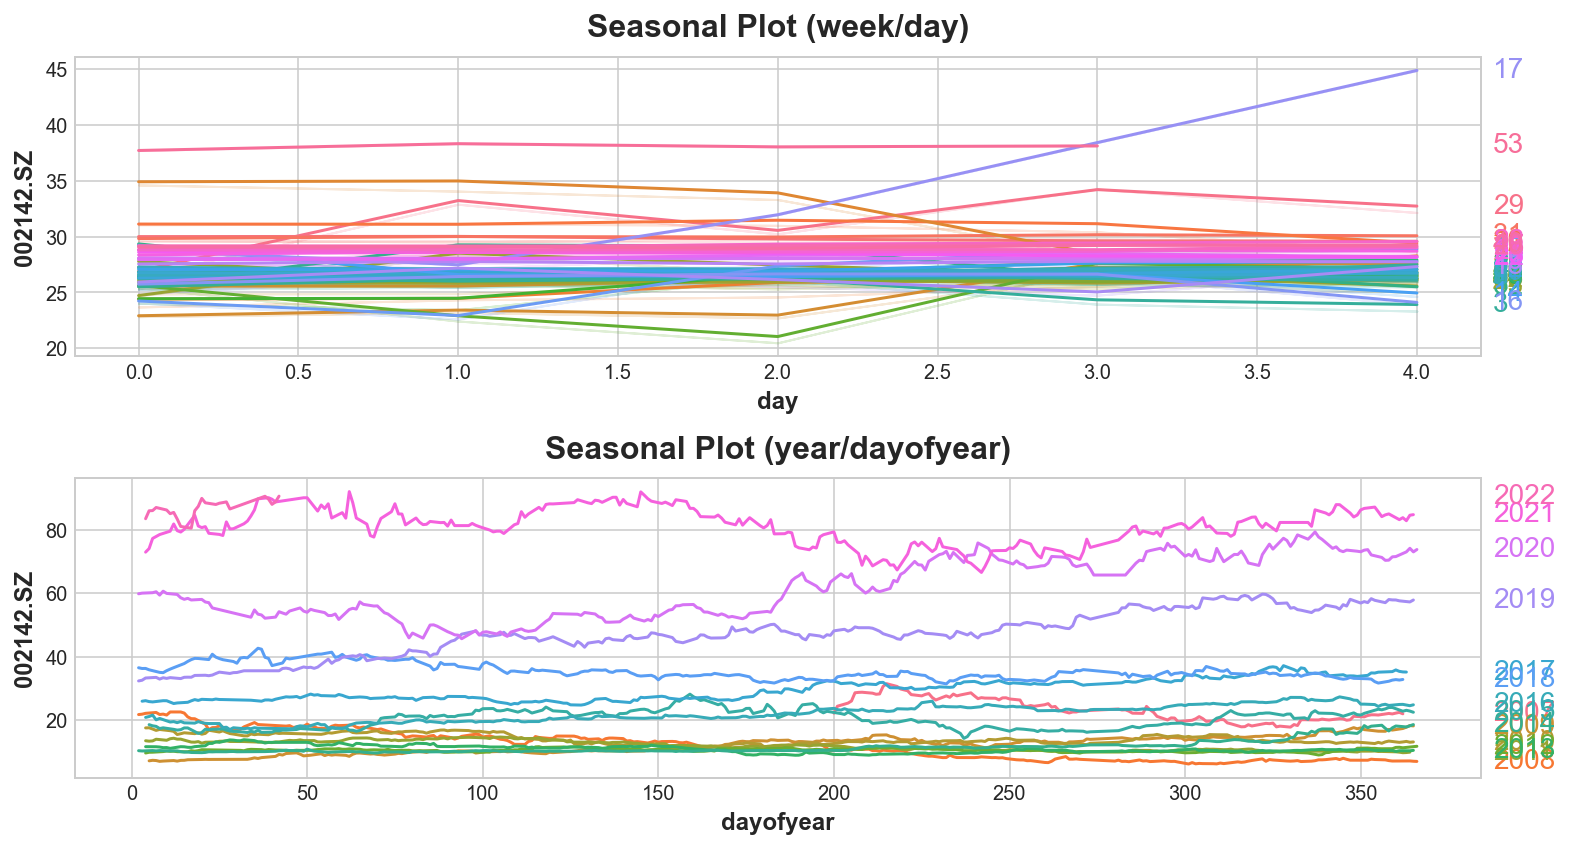

In [13]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="002142.SZ", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="002142.SZ", period="year", freq="dayofyear", ax=ax1);